In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Drumplot (Helicorder) With Data Select and Filtering
--

**Instructions**
1. Run the notebook. To do this, click 'Cell' in the dropdown menu, and then click 'Run All'.
2. Input boxes will appear below cell [16].
3. Select the date and the data stream, and then click 'Retrieve data'.
4. This may take a few moments. Once the data have been retrieved, a message will be displayed.
5. Move to the input boxes below cell [17].
6. If you want to filter the data, select the box labelled Filter? The default is no filtering. If you want to filter the waveform, you also need to select the bandpass filter range. The default is 0.1 to 10 Hz.
7. Depending on the amplitude of the signal, it may be necessary to adjust the plot gain, this scales the traces up or down. Some experimentation may be needed to find the best value. Try the default value first, it is suitable for many drumplots.
8. Click 'Show on screen' to display the drumplot below.
9. Large amplitudes are automatically clipped. The clip value is currently not adjustable.
10. You can repeat steps 6-8 as many times as you want, adjusting filter parameters and plot gains, to get the drumplot looking the way you want. Each time you click on 'Show on screen', a new drumplot will be produced and will show below any existing drumplots.
11. To produce an output file suitable for printing, click on 'Output to file'. This will produce a file that is visible in the Jupyter Hub file manager tab in your browser. To save that file, click on the file name to open a view of the helicorder in another browser tab, then right click on the image and select 'Save image as ...'.
12. The image will be named station.location.component.network_yyyymmdd_filter.drum.png. Examples are WIZ.10.HHZ.NZ_20171031_bandpass_0.1-4.6.drum.png and WIZ.10.HHZ.NZ_20171031_nofilt.drum.png.

In [18]:
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, Layout
%matplotlib inline

In [19]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [20]:
client = Client("GEONET")

In [21]:
current = False

In [22]:
#plot initialisation
filt = False
corners = 2
zerophase = False
defscale = 1e4
scale = defscale

#size ratio to match aspect ratio of print paper
xsize = 3200
ysize = int(xsize/1.4) 
size = (xsize,ysize)

#large trace clip
clip = 100000

In [23]:
def selsite(s):
  global site, stn, loc, cmp, net
  site = s['new']
  
  stn = site.split(".")[0]
  loc = site.split(".")[1]
  cmp = site.split(".")[2]
  net = site.split(".")[3]

In [24]:
def seldate(d):
  global pdate
  date = d['new']
  pdate = date.strftime("%Y%m%d")
  

In [25]:
def retrieve(r):
  global tr
  if (current):   #current data
    time = UTCDateTime()
    st = client.get_waveforms(str(net), str(stn), str(loc), str(cmp), time - 86400, time, attach_response=True)
  else:   #older data
    time = UTCDateTime(pdate)
    st = client.get_waveforms(str(net), str(stn), str(loc), str(cmp), time, time + 86400, attach_response=True)
  st.remove_sensitivity() 
  tr = st[0]
  tr.data *= 1e9 #convert from m/s to nm/s
  tr.data = np.clip(tr.data, clip*-1, clip)
  print 'data retrieved'
  print str(st)

In [26]:
def bandpass(bp):
  global lp, hp
  lp, hp  = bp['new']

In [27]:
def filter(f):
  global filt  
  filt = f['new']

In [28]:
def gain(g):
  global magn, scale  
  magn = g['new']
  scale = defscale / magn

In [29]:
def screen(c):
    if (filt):
        trcp = tr.copy()
        trcp.filter('bandpass', freqmin=lp, freqmax=hp, corners=corners, zerophase=zerophase)
        title = site+'_'+pdate+'_bandpass_'+str(lp)+'-'+str(hp)
        trcp.plot(type='dayplot', linewidth = 0.3, vertical_scaling_range= scale, size=size, color=('navy','blue','blue','blue'), title=title)
    else:
        title = site + '_' + pdate + '_nofilt'
        tr.plot(type='dayplot', linewidth = 0.3, vertical_scaling_range= scale, size=size, color=('navy','blue','blue','blue'), title=title)

In [30]:
def output(o):
    if (filt):
        trcp = tr.copy()
        trcp.filter('bandpass', freqmin=lp, freqmax=hp, corners=corners, zerophase=zerophase)
        title = site+'_'+pdate+'_bandpass_'+str(lp)+'-'+str(hp)
        trcp.plot(type='dayplot', linewidth = 0.3, vertical_scaling_range= scale, size=size, color=('navy','blue','blue','blue'), title=title, outfile=title+'.drum.png')
    else:
        title = site+'_'+pdate+'_nofilt'
        tr.plot(type='dayplot', linewidth = 0.3, vertical_scaling_range= scale, size=size, color=('navy','blue','blue','blue'), title=title, outfile=title+'.drum.png')

In [31]:
s = widgets.Select(
    options=['select stream', 'WIZ.10.HHZ.NZ', 'WSRZ.10.HHZ.NZ', 'MAVZ.10.HHZ.NZ', 'FWVZ.10.HHZ.NZ', 'WHVZ.10.HHZ.NZ', 'TRVZ.10.HHZ.NZ', 'GLKZ.10.HHZ.NZ'],
    value='select stream',
    description='Stream to display:',
    disabled=False
)
s.observe(selsite, names='value')

d = widgets.DatePicker(
  description='Date to display:')
d.observe(seldate, names='value')

r=widgets.Button(
    description='Retrieve data',
    disabled=False,
    button_style='success',
    tooltip='Retrieve data for plotting')
r.on_click(retrieve)

widgets.HBox([d, s, r])

FDSNNoDataException: No data available for request.
Detailed response of server:



data retrieved
1 Trace(s) in Stream:
NZ.WIZ.10.HHZ | 2017-10-22T23:59:57.703226Z - 2017-10-24T00:00:03.723226Z | 100.0 Hz, 8640603 samples
data retrieved
1 Trace(s) in Stream:
NZ.WIZ.10.HHZ | 2017-10-29T23:59:57.822967Z - 2017-10-30T00:00:01.702967Z | 100.0 Hz, 389 samples
data retrieved
1 Trace(s) in Stream:
NZ.WIZ.10.HHZ | 2017-10-28T23:59:57.723003Z - 2017-10-30T00:00:01.703003Z | 100.0 Hz, 8640399 samples


/usr/lib/python2.7/dist-packages/obspy/imaging/waveform.py:932: RuntimeWarning: invalid value encountered in double_scalars
  self.extreme_values.size


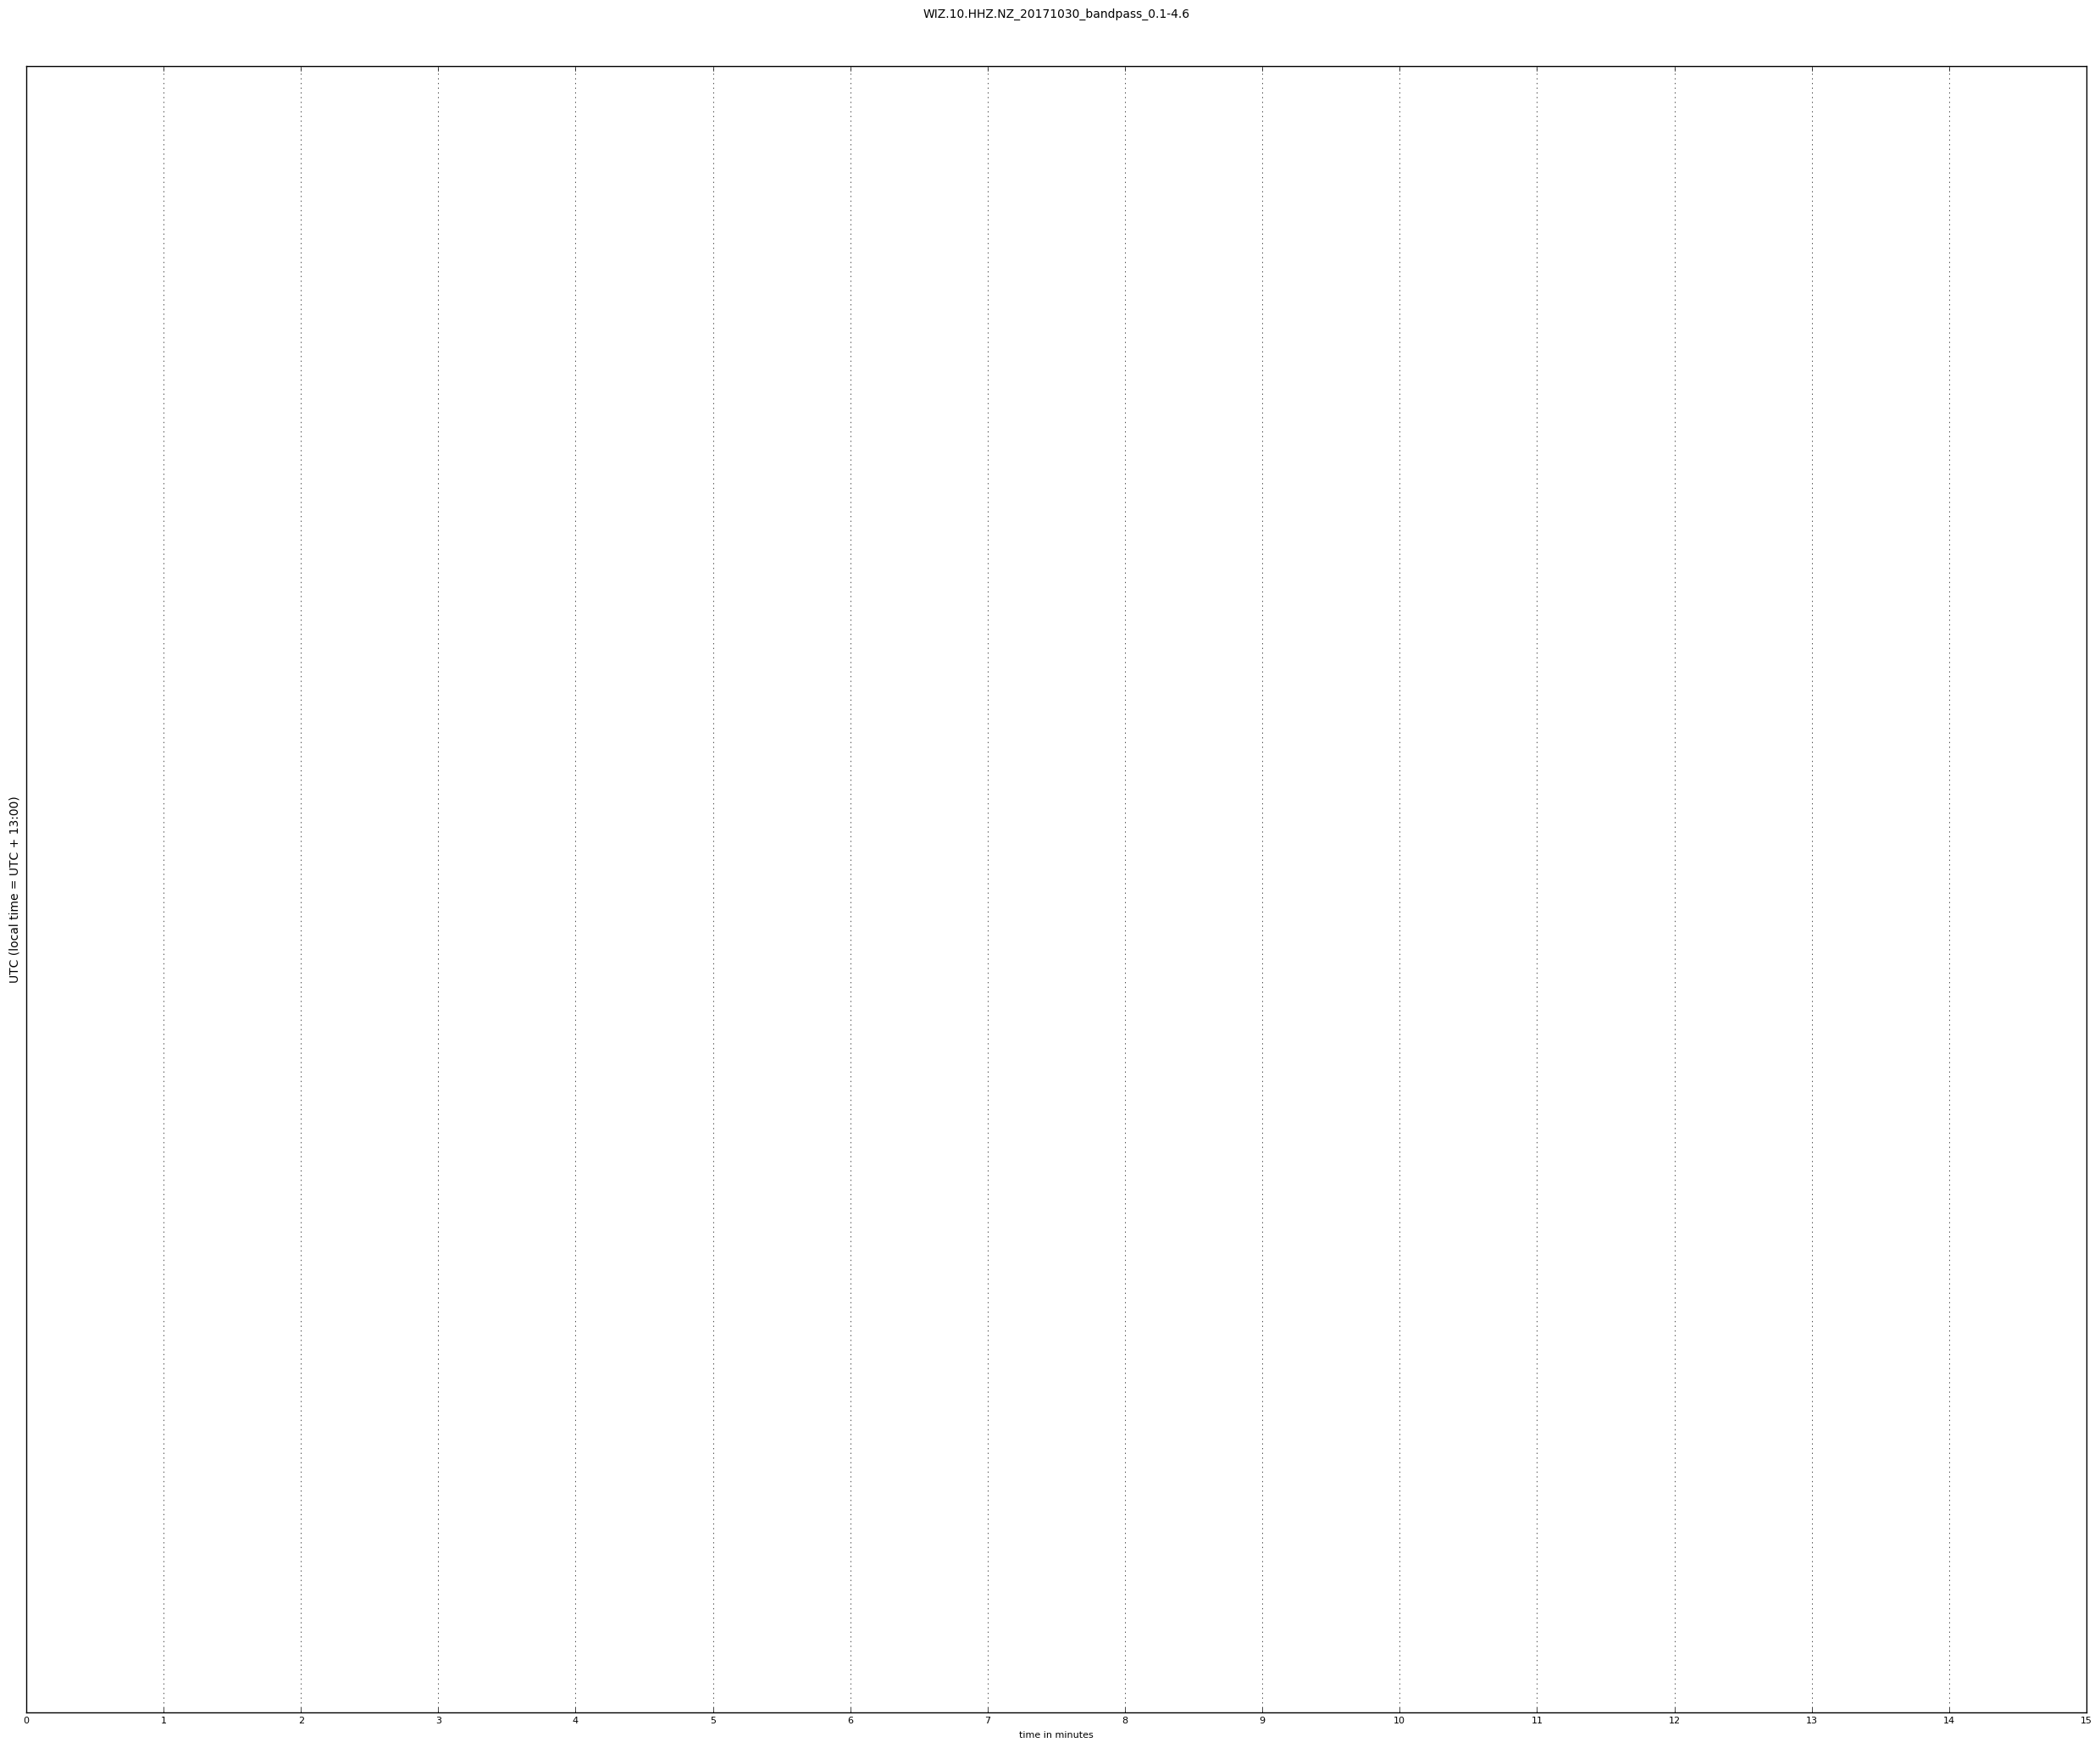

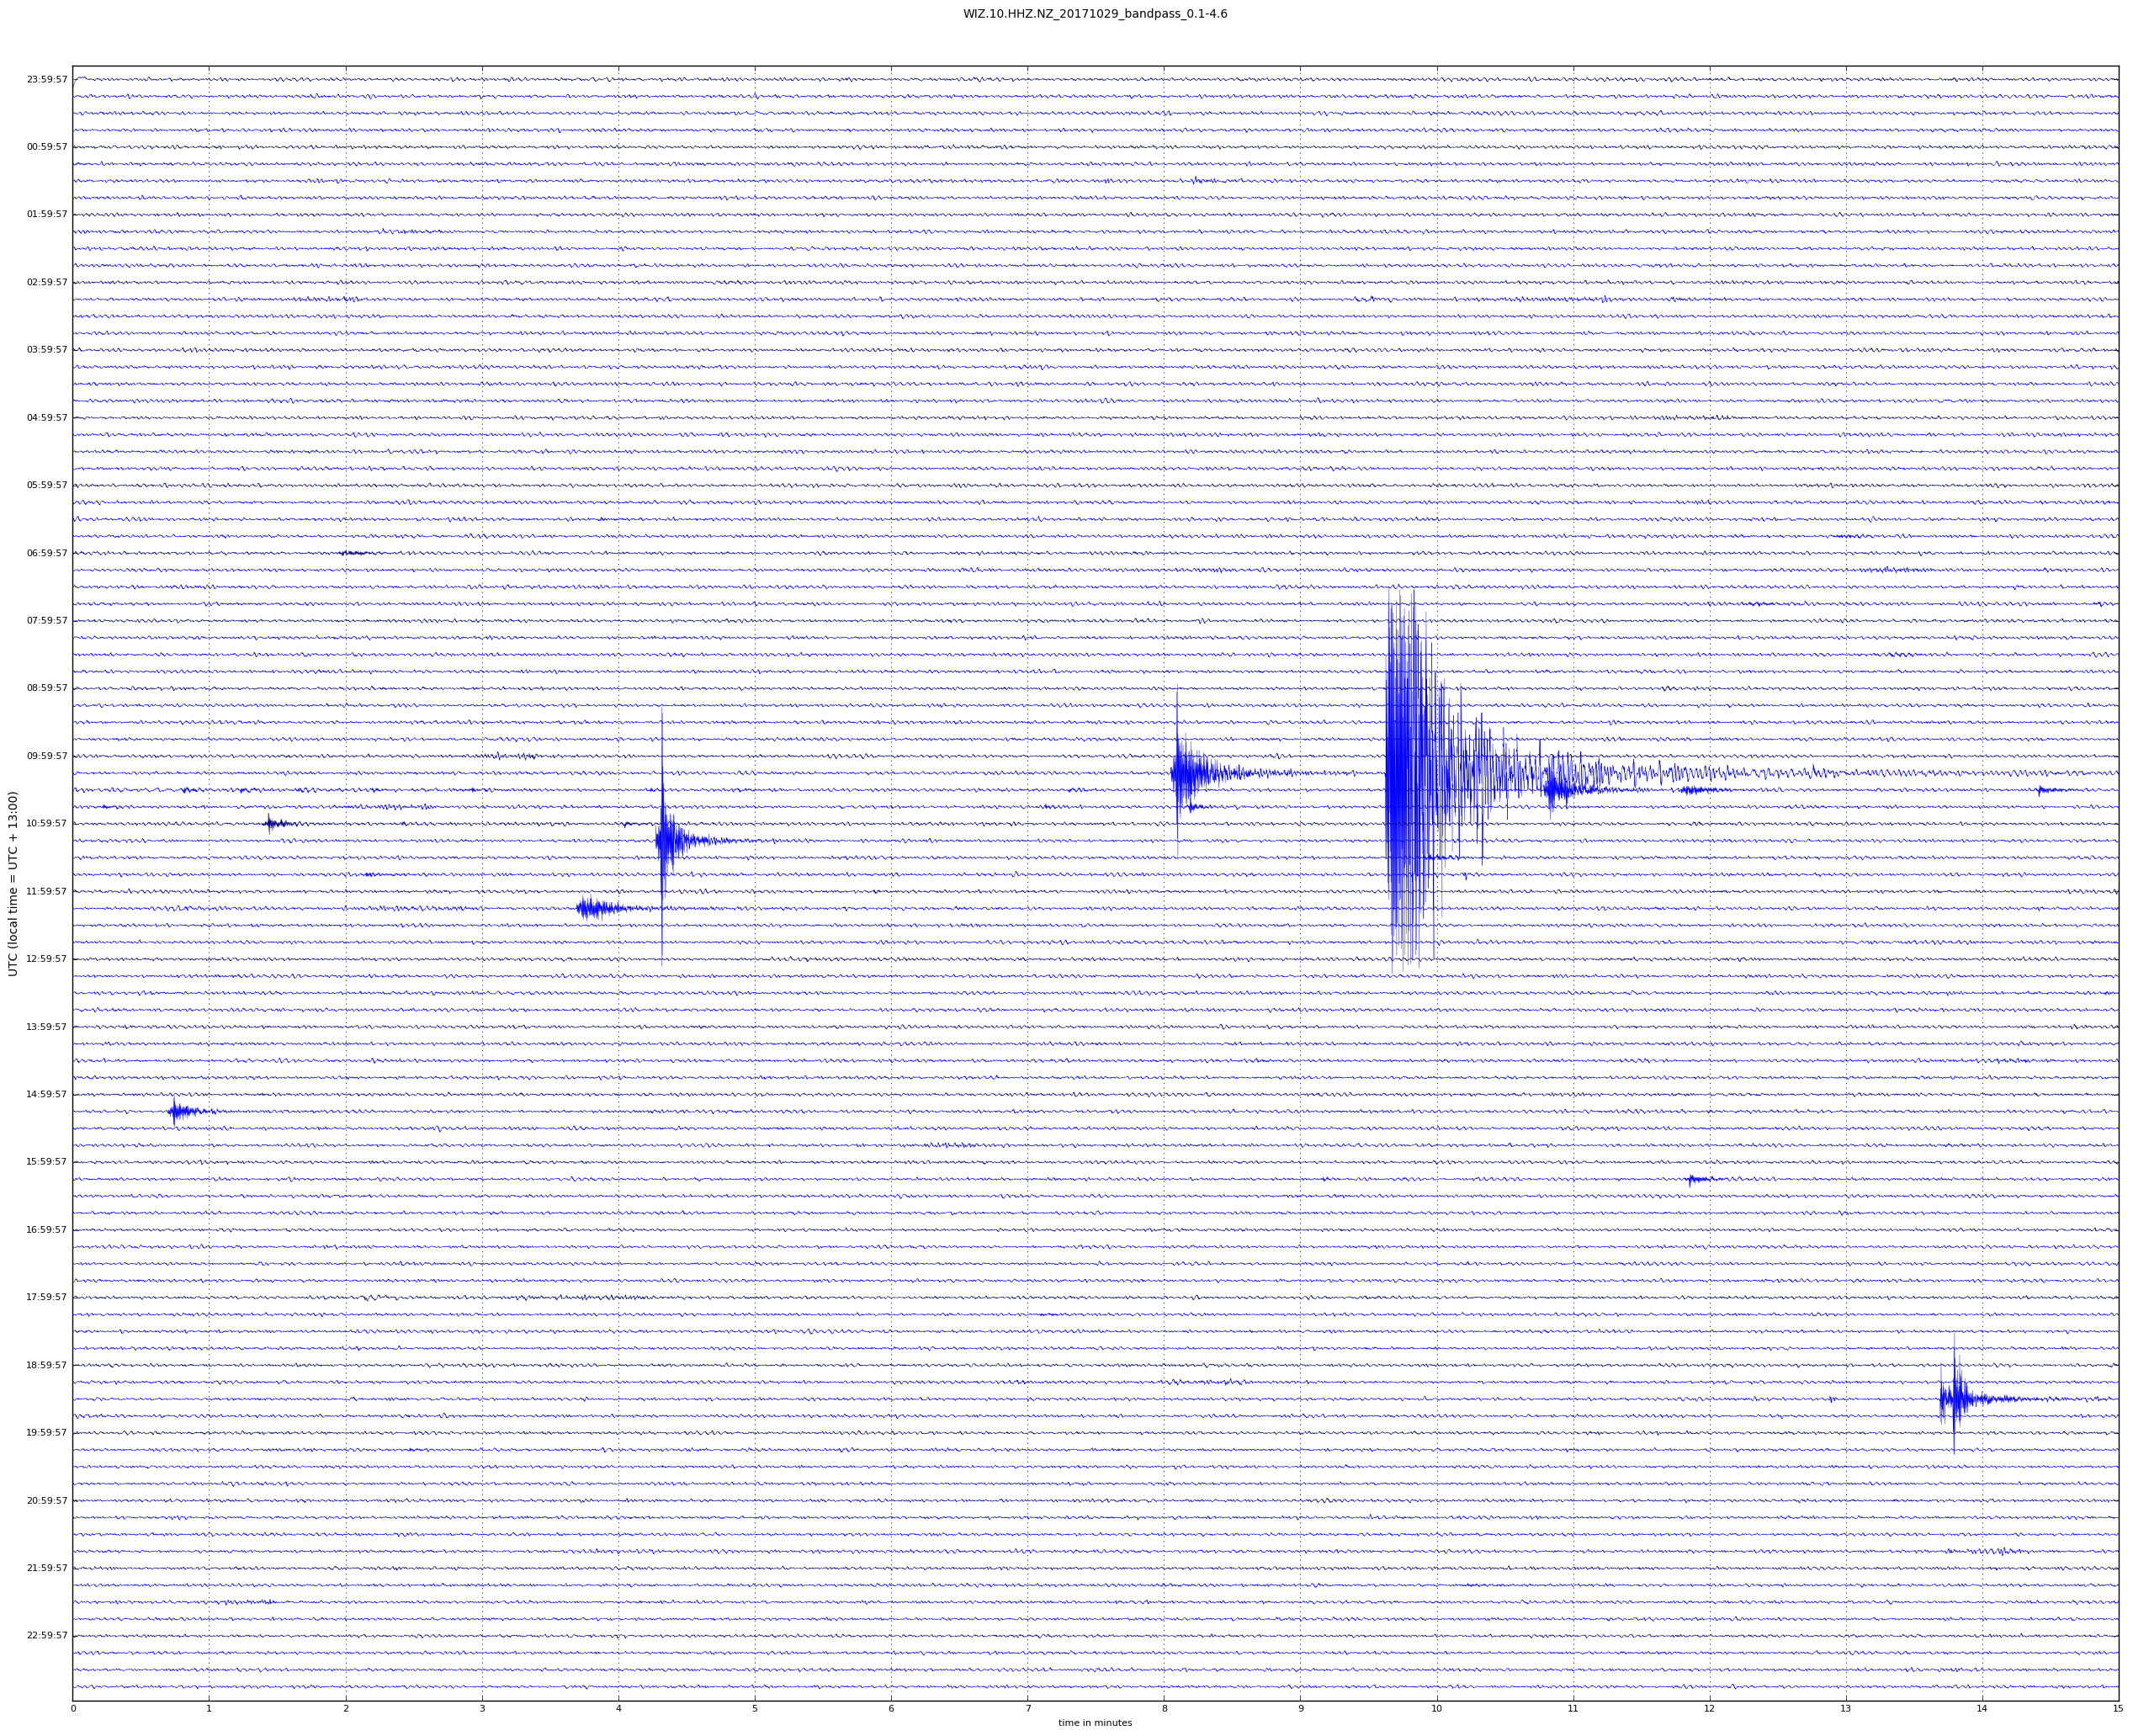

In [32]:
f=widgets.Checkbox(
    description='Filter?',
    value=False,
    tooltip='Set filtering',
    disabled=False,
    layout=widgets.Layout(width='10%'))
f.observe(filter,names='value')

b=widgets.FloatRangeSlider(
    value=[0.1, 10],
    min=0.05,
    max=10,
    step=0.05,
    description='band-pass:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    slider_color='white')
b.observe(bandpass, names='value')

g=widgets.FloatSlider(
    value=1,
    min=0.1,
    max=10,
    step=0.1,
    description='plot gain:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    slider_color='white')
g.observe(gain, names='value')

widgets.HBox([f,b,g])

c=widgets.Button(
    description='Show on screen',
    disabled=False,
    button_style='success',
    tooltip='Make drumplot')
c.on_click(screen)

o=widgets.Button(
    description='Output to file',
    disabled=False,
    button_style='success',
    tooltip='Make file copy')
o.on_click(output)

widgets.HBox([f, b, g, c, o])